In [346]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import math
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pickle

In [347]:
data = pd.read_csv('Tomato.csv')

In [348]:
#Drop na's.
data.dropna(axis=0, inplace=True) #remove all rows with na's.
data.reset_index(drop=True)

,Date,Centre_Name,Commodity_Name,Price
0,2001-01-09,DELHI,Tomato,34
1,2001-01-09,MUMBAI,Tomato,26
2,2001-01-10,DELHI,Tomato,13
3,2001-01-13,DELHI,Tomato,15
4,2001-01-13,MUMBAI,Tomato,17
...,...,...,...,...
1819,2015-12-11,MUMBAI,Tomato,16
1820,2015-12-11,KOLKATA,Tomato,18
1821,2015-12-14,DELHI,Tomato,26
1822,2015-12-14,MUMBAI,Tomato,24


In [349]:
#calculate average price for each centre for each day 
data_gp = data.sort_values('Date').groupby(['Centre_Name', 'Date'], as_index=False)
data_gp = data_gp.agg({'Price':['mean']})
data_gp.columns = ['Centre_Name', 'Date', 'Price']
data_gp.head()

,Centre_Name,Date,Price
0,DELHI,2001-01-09,34
1,DELHI,2001-01-10,13
2,DELHI,2001-01-13,15
3,DELHI,2001-01-14,30
4,DELHI,2001-01-15,36


In [350]:
#centre_1_train_dataset
centre_1_data = data_gp.loc[(data_gp['Centre_Name']=="DELHI"),["Price"]].values
centre_1_data = centre_1_data.astype("float32")

#centre_2_train_dataset
centre_2_data = data_gp.loc[(data_gp['Centre_Name']=="KOLKATA"),["Price"]].values
centre_2_data = centre_2_data.astype("float32")

#centre_2_train_dataset
centre_3_data = data_gp.loc[(data_gp['Centre_Name']=="MUMBAI"),["Price"]].values
centre_3_data = centre_3_data.astype("float32")

print(centre_1_data.size,centre_2_data.size,centre_3_data.size)

774 446 604


In [351]:
#take last year as test dataset
train_centre_1 = centre_1_data[:-365]
test_centre_1 = centre_1_data[-365:]

train_centre_2 = centre_2_data[:-365]
test_centre_2 = centre_2_data[-365:]

train_centre_3 = centre_3_data[:-365]
test_centre_3 = centre_3_data[-365:]

print("train size: {}, test size: {}".format(len(train_centre_1), len(test_centre_1)))

train size: 409, test size: 365


In [352]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#transform the data using minmax scaler
scaler_2 = MinMaxScaler(feature_range=(0,1))
scaler_3 = MinMaxScaler(feature_range=(0,1))

train_centre_1 = scaler.fit_transform(train_centre_1)
test_centre_1 = scaler.transform(test_centre_1)

train_centre_2 = scaler_2.fit_transform(train_centre_2)
test_centre_2 = scaler_2.transform(test_centre_2)

train_centre_3 = scaler_3.fit_transform(train_centre_3)
test_centre_3 = scaler_3.transform(test_centre_3)

In [353]:
#train:

time_step = 30
datax_centre_1=[]
datay_centre_1=[]

for i in range(len(train_centre_1)-time_step-1):
    datax_centre_1.append(train_centre_1[i:(i+time_step),0])
    datay_centre_1.append(train_centre_1[i+time_step,0])
trainx_centre_1=np.array(datax_centre_1)
trainy_centre_1=np.array(datay_centre_1)

datax_centre_2=[]
datay_centre_2=[]

for i in range(len(train_centre_2)-time_step-1):
    datax_centre_2.append(train_centre_2[i:(i+time_step),0])
    datay_centre_2.append(train_centre_2[i+time_step,0])
trainx_centre_2=np.array(datax_centre_2)
trainy_centre_2=np.array(datay_centre_2)

datax_centre_3=[]
datay_centre_3=[]

for i in range(len(train_centre_3)-time_step-1):
    datax_centre_3.append(train_centre_3[i:(i+time_step),0])
    datay_centre_3.append(train_centre_3[i+time_step,0])
trainx_centre_3=np.array(datax_centre_3)
trainy_centre_3=np.array(datay_centre_3)

In [354]:
#test:

datax_centre_1=[]
datay_centre_1=[]

for i in range(len(test_centre_1)-time_step-1):
    datax_centre_1.append(test_centre_1[i:(i+time_step),0])
    datay_centre_1.append(test_centre_1[i+time_step,0])
testx_centre_1=np.array(datax_centre_1)
testy_centre_1=np.array(datay_centre_1)


datax_centre_2=[]
datay_centre_2=[]

for i in range(len(test_centre_2)-time_step-1):
    datax_centre_2.append(test_centre_2[i:(i+time_step),0])
    datay_centre_2.append(test_centre_2[i+time_step,0])
testx_centre_2=np.array(datax_centre_2)
testy_centre_2=np.array(datay_centre_2)

datax_centre_3=[]
datay_centre_3=[]

for i in range(len(test_centre_3)-time_step-1):
    datax_centre_3.append(test_centre_3[i:(i+time_step),0])
    datay_centre_3.append(test_centre_3[i+time_step,0])
testx_centre_3=np.array(datax_centre_3)
testy_centre_3=np.array(datay_centre_3)

In [355]:
trainx_centre_1=np.reshape(trainx_centre_1, (trainx_centre_1.shape[0],1,trainx_centre_1.shape[1]))
testx_centre_1=np.reshape(testx_centre_1, (testx_centre_1.shape[0],1,testx_centre_1.shape[1]))

trainx_centre_2=np.reshape(trainx_centre_2, (trainx_centre_2.shape[0],1,trainx_centre_2.shape[1]))
testx_centre_2=np.reshape(testx_centre_2, (testx_centre_2.shape[0],1,testx_centre_2.shape[1]))

trainx_centre_3=np.reshape(trainx_centre_3, (trainx_centre_3.shape[0],1,trainx_centre_3.shape[1]))
testx_centre_3=np.reshape(testx_centre_3, (testx_centre_3.shape[0],1,testx_centre_3.shape[1]))


In [356]:
model =Sequential()
model.add(LSTM(20, input_shape=(1, time_step))) #20 LSTM neuron
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_1 = model.fit(trainx_centre_1, trainy_centre_1, epochs=100, batch_size=32,    validation_split=0.1, shuffle=False)

Epoch 1/100
11/11 [==============================] - 0s 33ms/step - loss: 1.0346 - val_loss: 1.1360
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 0.9949 - val_loss: 1.0861
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 0.9635 - val_loss: 1.0436
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.9363 - val_loss: 1.0071
Epoch 5/100
11/11 [==============================] - 0s 4ms/step - loss: 0.9125 - val_loss: 0.9751
Epoch 6/100
11/11 [==============================] - 0s 4ms/step - loss: 0.8910 - val_loss: 0.9469
Epoch 7/100
11/11 [==============================] - 0s 4ms/step - loss: 0.8713 - val_loss: 0.9217
Epoch 8/100
11/11 [==============================] - 0s 4ms/step - loss: 0.8531 - val_loss: 0.8992
Epoch 9/100
11/11 [==============================] - 0s 4ms/step - loss: 0.8361 - val_loss: 0.8790
Epoch 10/100
11/11 [==============================] - 0s 4ms/step - loss: 0.8199 - val_loss: 0.8611
Epoch 11

11/11 [==============================] - 0s 3ms/step - loss: 0.1147 - val_loss: 0.8794
Epoch 84/100
11/11 [==============================] - 0s 3ms/step - loss: 0.1108 - val_loss: 0.8830
Epoch 85/100
11/11 [==============================] - 0s 3ms/step - loss: 0.1071 - val_loss: 0.8865
Epoch 86/100
11/11 [==============================] - 0s 3ms/step - loss: 0.1034 - val_loss: 0.8900
Epoch 87/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0999 - val_loss: 0.8935
Epoch 88/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0964 - val_loss: 0.8969
Epoch 89/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0931 - val_loss: 0.9003
Epoch 90/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0898 - val_loss: 0.9037
Epoch 91/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0867 - val_loss: 0.9070
Epoch 92/100
11/11 [==============================] - 0s 3ms/step - loss: 0.0837 - val_loss: 0.9103
Epoch 93/100


In [357]:
model_2 =Sequential()
model_2.add(LSTM(20, input_shape=(1, time_step))) #20 LSTM neuron
model_2.add(Dense(1))
model_2.compile(loss='mean_squared_error', optimizer='adam')
history_2 = model.fit(trainx_centre_2, trainy_centre_2, epochs=100, batch_size=32,   validation_split=0.1, shuffle=False)

Epoch 1/100
2/2 [==============================] - 0s 24ms/step - loss: 0.1544 - val_loss: 0.3160
Epoch 2/100
2/2 [==============================] - 0s 12ms/step - loss: 0.1412 - val_loss: 0.2763
Epoch 3/100
2/2 [==============================] - 0s 12ms/step - loss: 0.1201 - val_loss: 0.2286
Epoch 4/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0985 - val_loss: 0.1815
Epoch 5/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0812 - val_loss: 0.1404
Epoch 6/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0702 - val_loss: 0.1078
Epoch 7/100
2/2 [==============================] - 0s 11ms/step - loss: 0.0647 - val_loss: 0.0840
Epoch 8/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0628 - val_loss: 0.0677
Epoch 9/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0619 - val_loss: 0.0574
Epoch 10/100
2/2 [==============================] - 0s 11ms/step - loss: 0.0605 - val_loss: 0.0513
Epoch 11/100
2/2 [=

Epoch 84/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0203 - val_loss: 0.0288
Epoch 85/100
2/2 [==============================] - 0s 15ms/step - loss: 0.0202 - val_loss: 0.0288
Epoch 86/100
2/2 [==============================] - 0s 11ms/step - loss: 0.0201 - val_loss: 0.0288
Epoch 87/100
2/2 [==============================] - 0s 11ms/step - loss: 0.0201 - val_loss: 0.0289
Epoch 88/100
2/2 [==============================] - 0s 10ms/step - loss: 0.0200 - val_loss: 0.0289
Epoch 89/100
2/2 [==============================] - 0s 11ms/step - loss: 0.0200 - val_loss: 0.0289
Epoch 90/100
2/2 [==============================] - 0s 10ms/step - loss: 0.0199 - val_loss: 0.0289
Epoch 91/100
2/2 [==============================] - 0s 11ms/step - loss: 0.0198 - val_loss: 0.0289
Epoch 92/100
2/2 [==============================] - 0s 10ms/step - loss: 0.0198 - val_loss: 0.0290
Epoch 93/100
2/2 [==============================] - 0s 10ms/step - loss: 0.0197 - val_loss: 0.0290
Epoch 94/1

In [358]:
model_3 =Sequential()
model_3.add(LSTM(20, input_shape=(1, time_step))) #20 LSTM neuron
model_3.add(Dense(1))
model_3.compile(loss='mean_squared_error', optimizer='adam')
history_3 = model.fit(trainx_centre_3, trainy_centre_3, epochs=100, batch_size=32,  validation_split=0.1, shuffle=False) 

Epoch 1/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0320 - val_loss: 0.0442
Epoch 2/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0315 - val_loss: 0.0439
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0309 - val_loss: 0.0436
Epoch 4/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0303 - val_loss: 0.0432
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0297 - val_loss: 0.0428
Epoch 6/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0291 - val_loss: 0.0424
Epoch 7/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0285 - val_loss: 0.0420
Epoch 8/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0280 - val_loss: 0.0417
Epoch 9/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0275 - val_loss: 0.0414
Epoch 10/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0271 - val_loss: 0.0411
Epoch 11/100
6/6 [===========

6/6 [==============================] - 0s 5ms/step - loss: 0.0189 - val_loss: 0.0361
Epoch 85/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0189 - val_loss: 0.0361
Epoch 86/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0188 - val_loss: 0.0361
Epoch 87/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0188 - val_loss: 0.0361
Epoch 88/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0187 - val_loss: 0.0360
Epoch 89/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0187 - val_loss: 0.0360
Epoch 90/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0187 - val_loss: 0.0360
Epoch 91/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0186 - val_loss: 0.0360
Epoch 92/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0186 - val_loss: 0.0360
Epoch 93/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0186 - val_loss: 0.0360
Epoch 94/100
6/6 [===============

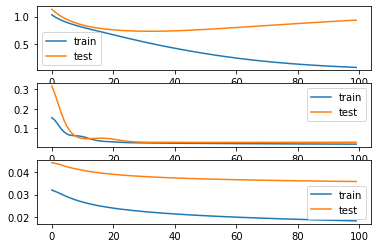

In [359]:
fig = plt.figure()
plt.subplot(3, 1, 1)
plt.plot(history_1.history['loss'], label='train')
plt.plot(history_1.history['val_loss'], label='test')
plt.legend();

plt.subplot(3, 1, 2)
plt.plot(history_2.history['loss'], label='train')
plt.plot(history_2.history['val_loss'], label='test')
plt.legend();

plt.subplot(3, 1, 3)
plt.plot(history_3.history['loss'], label='train')
plt.plot(history_3.history['val_loss'], label='test')
plt.legend();

In [360]:
trainy_centre_1 = trainy_centre_1.reshape(1,-1)
testy_centre_1 = testy_centre_1.reshape(1,-1)

trainy_centre_2 = trainy_centre_2.reshape(1,-1)
testy_centre_2 = testy_centre_2.reshape(1,-1)

trainy_centre_3 = trainy_centre_3.reshape(1,-1)
testy_centre_3 = testy_centre_3.reshape(1,-1)

In [361]:
testPredict_centre_1 = model.predict(testx_centre_1)
testPredict_centre_1 = scaler.inverse_transform(testPredict_centre_1)
testy_centre_1 = scaler.inverse_transform(testy_centre_1)
trainPredict_centre_1 = model.predict(trainx_centre_1)
trainPredict_centre_1 = scaler.inverse_transform(trainx_centre_1)
trainy_centre_1 = scaler.inverse_transform(trainy_centre_1)

testPredict_centre_2 = model.predict(testx_centre_2)
trainPredict_centre_2 = model.predict(trainx_centre_2)
trainPredict_centre_2 = scaler.inverse_transform(trainx_centre_2)
testPredict_centre_2 = scaler.inverse_transform(testPredict_centre_2)
testy_centre_2 = scaler.inverse_transform(testy_centre_2)
trainy_centre_2 = scaler.inverse_transform(trainy_centre_2)

testPredict_centre_3 = model.predict(testx_centre_3)
trainPredict_centre_3 = model.predict(trainx_centre_3)
trainPredict_centre_3 = scaler.inverse_transform(trainx_centre_3)
testPredict_centre_3 = scaler.inverse_transform(testPredict_centre_3)
testy_centre_3 = scaler.inverse_transform(testy_centre_3)
trainy_centre_3 = scaler.inverse_transform(trainy_centre_3)

<Figure size 432x288 with 0 Axes>

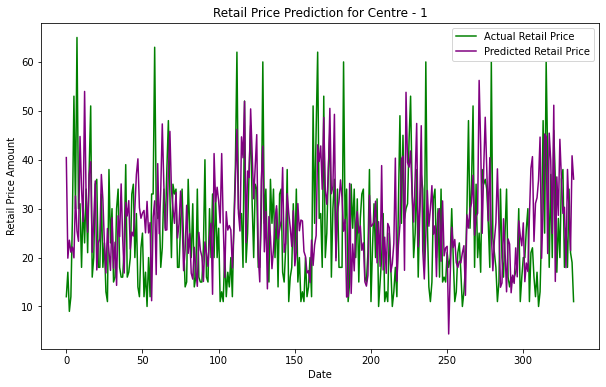

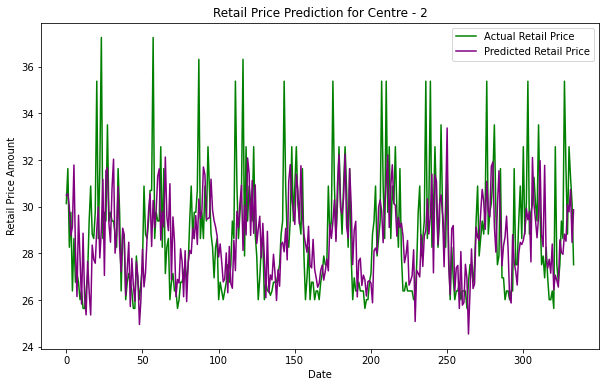

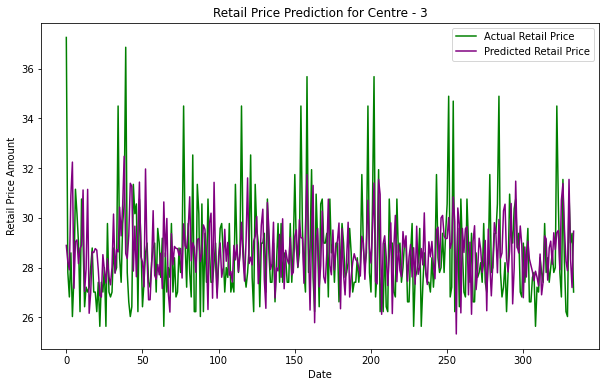

In [362]:
fig = plt.figure()
plt.figure(figsize=(10,6))
plt.plot(testy_centre_1[0], color='green', label='Actual Retail Price')
plt.plot(testPredict_centre_1 , color='purple', label='Predicted Retail Price')
plt.title('Retail Price Prediction for Centre - 1')
plt.xlabel('Date')
plt.ylabel('Retail Price Amount')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(testy_centre_2[0], color='green', label='Actual Retail Price')
plt.plot(testPredict_centre_2 , color='purple', label='Predicted Retail Price')
plt.title('Retail Price Prediction for Centre - 2')
plt.xlabel('Date')
plt.ylabel('Retail Price Amount')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(testy_centre_3[0], color='green', label='Actual Retail Price')
plt.plot(testPredict_centre_3 , color='purple', label='Predicted Retail Price')
plt.title('Retail Price Prediction for Centre - 3')
plt.xlabel('Date')
plt.ylabel('Retail Price Amount')
plt.legend()
plt.show()

In [363]:
# trainscore = math.sqrt(mean_squared_error(trainy_centre_1[0], trainPredict_centre_1[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_1[0], testPredict_centre_1[:,0]))
# print("Train MSE: {}, Test MSE: {}".format(trainscore, testscore))

# trainscore = math.sqrt(mean_squared_error(trainy_centre_1[0], trainPredict_centre_1[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_1[0], testPredict_centre_1[:,0]))
# print("Train MSE for centre 1 model : {}, Test MSE: {}".format(trainscore, testscore))

# trainscore = math.sqrt(mean_squared_error(trainy_centre_2[0], trainPredict_centre_2[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_2[0], testPredict_centre_2[:,0]))
# print("Train MSE for centre 2 model : {}, Test MSE: {}".format(trainscore, testscore))

# trainscore = math.sqrt(mean_squared_error(trainy_centre_3[0], trainPredict_centre_3[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_3[0], testPredict_centre_3[:,0]))
# print("Train MSE for centre 3 model : {}, Test MSE: {}".format(trainscore, testscore))

In [364]:
print(trainy_centre_2[0], trainPredict_centre_2[:,0])

[26.015009 26.389431 26.015009 26.389431 26.763851 26.015009 27.138273
 26.015009 27.138273 28.63596  29.759226 35.37555  29.759226 28.63596
 30.69528  31.631332 28.63596  29.384804 34.439495 30.133646 29.384804
 28.823172 33.50344  29.384804 26.951063 27.138273 28.823172 26.015009
 27.138273 26.951063 25.640587 26.389431 26.015009 26.389431 26.763851
 26.015009 27.138273 26.015009 27.512695 30.88249  28.823172 29.759226
 35.37555  29.759226 28.63596  30.69528  29.759226 29.384804 34.439495
 29.384804] [[27.138273 26.015009 26.015009 ... 28.63596  26.015009 26.951063]
 [26.015009 26.015009 26.015009 ... 26.015009 26.951063 26.015009]
 [26.015009 26.015009 26.389431 ... 26.951063 26.015009 26.389431]
 ...
 [29.384804 34.439495 30.133646 ... 28.63596  30.69528  29.759226]
 [34.439495 30.133646 29.384804 ... 30.69528  29.759226 29.384804]
 [30.133646 29.384804 28.823172 ... 29.759226 29.384804 34.439495]]


# Predicting 90 days of 2015

In [365]:
#use retail price of last 30 days of 2014 to predict next 90 days

#centre-1
testPredict_centre_1 = []

x_data_centre_1 = testx_centre_1[-1] #get transformed retail price values of last 30 days 
x_centre_1 = np.reshape(x_data_centre_1,(1,1,30))
yhat = model.predict(x_centre_1)
testPredict_centre_1 = np.append(testPredict_centre_1,scaler.inverse_transform(yhat))
x_data_centre_1 = np.append(x_data_centre_1,yhat)

for i in range (89):
        x_data_centre_1 = x_data_centre_1[1:]
        x_centre_1 = np.reshape(x_data_centre_1,(1,1,30))
        yhat = model.predict(x_centre_1)
        testPredict_centre_1 = np.append(testPredict_centre_1,scaler.inverse_transform(yhat))
        x_data_centre_1 = np.append(x_data_centre_1,yhat)
        
#centre-2     
testPredict_centre_2 = []

x_data_centre_2 = testx_centre_2[-1] #get transformed retail price values of last 30 days 
x_centre_2 = np.reshape(x_data_centre_2,(1,1,30))
yhat = model.predict(x_centre_2)
testPredict_centre_2 = np.append(testPredict_centre_2,scaler.inverse_transform(yhat))
x_data_centre_2 = np.append(x_data_centre_2,yhat)

for i in range (89):
        x_data_centre_2 = x_data_centre_2[1:]
        x_centre_2 = np.reshape(x_data_centre_2,(1,1,30))
        yhat = model.predict(x_centre_2)
        testPredict_centre_2 = np.append(testPredict_centre_2,scaler.inverse_transform(yhat))
        x_data_centre_2 = np.append(x_data_centre_2,yhat)
        
#centre-3
testPredict_centre_3 = []

x_data_centre_3 = testx_centre_3[-1] #get transformed retail price values of last 30 days 
x_centre_3 = np.reshape(x_data_centre_3,(1,1,30))
yhat = model.predict(x_centre_3)
testPredict_centre_3 = np.append(testPredict_centre_3,scaler.inverse_transform(yhat))
x_data_centre_3 = np.append(x_data_centre_3,yhat)

for i in range (89):
        x_data_centre_3 = x_data_centre_3[1:]
        x_centre_3 = np.reshape(x_data_centre_3,(1,1,30))
        yhat = model.predict(x_centre_3)
        testPredict_centre_3 = np.append(testPredict_centre_3,scaler.inverse_transform(yhat))
        x_data_centre_3 = np.append(x_data_centre_3,yhat)
        


In [366]:
#Create Dataframe with predicted retail prices
centre_1_test_df = pd.DataFrame(columns = ['Date','Centre_Name','Predicted_Retail_Price'])
centre_1_test_df['Date']=pd.date_range(start='1/1/2015' ,end = '31/3/2015', freq='D')
centre_1_test_df['Centre_Name'] = "DELHI"
centre_1_test_df['Predicted_Retail_Price'] = testPredict_centre_1

#Create Dataframe with predicted retail prices
centre_2_test_df = pd.DataFrame(columns = ['Date','Centre_Name','Predicted_Retail_Price'])
centre_2_test_df['Date']=pd.date_range(start='1/1/2015' ,end = '31/3/2015', freq='D')
centre_2_test_df['Centre_Name'] = "KOLKATA"
centre_2_test_df['Predicted_Retail_Price'] = testPredict_centre_2

#Create Dataframe with predicted retail prices
centre_3_test_df = pd.DataFrame(columns = ['Date','Centre_Name','Predicted_Retail_Price'])
centre_3_test_df['Date']=pd.date_range(start='1/1/2015' ,end = '31/3/2015', freq='D')
centre_3_test_df['Centre_Name'] = "MUMBAI"
centre_3_test_df['Predicted_Retail_Price'] = testPredict_centre_3

test_df = pd.concat([centre_1_test_df , centre_2_test_df, centre_3_test_df],ignore_index=True)
test_df

,Date,Centre_Name,Predicted_Retail_Price
0,2015-01-01,DELHI,36.045879
1,2015-01-02,DELHI,35.956345
2,2015-01-03,DELHI,24.706390
3,2015-01-04,DELHI,12.303117
4,2015-01-05,DELHI,25.593241
...,...,...,...
265,2015-03-27,MUMBAI,28.832523
266,2015-03-28,MUMBAI,28.856251
267,2015-03-29,MUMBAI,28.840385
268,2015-03-30,MUMBAI,28.809017


In [367]:
test_df.to_csv('lstm_price_prediction_tomato.csv',index=False)